In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import os
from PIL import Image
import pandas as pd
import numpy as np
from tqdm import tqdm

In [26]:
print(f"Is CUDA available? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"Device count: {torch.cuda.device_count()}")

Is CUDA available? True
CUDA version: 11.8
Device count: 1


In [27]:
DATA_DIR = r'C:\Files\Kavan (Internship & Activity)\Hackathon\Cognizant_NPN\Age Prediction\1-100'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 20

In [28]:
class AgeDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.ages = []
        for age_folder in os.listdir(data_dir):
            age_path = os.path.join(data_dir, age_folder)
            if os.path.isdir(age_path):
                for img_file in os.listdir(age_path):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(age_path, img_file))
                        self.ages.append(float(age_folder))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        age = torch.tensor(self.ages[idx], dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        return image, age.unsqueeze(0)

In [29]:
# Data Transformation and Augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [30]:
# Datasets and DataLoaders
train_dataset = AgeDataset(data_dir=os.path.join(DATA_DIR, 'train'), transform=train_transform)
test_dataset = AgeDataset(data_dir=os.path.join(DATA_DIR, 'test'), transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Training data points: {len(train_dataset)}")
print(f"Testing data points: {len(test_dataset)}")
print(f"Device: {DEVICE}")

Training data points: 185632
Testing data points: 47568
Device: cuda


In [31]:
# Model Architecture
model = models.resnet34(weights='IMAGENET1K_V1')
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1) 
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
# Loss Function and Optimizer
criterion = nn.L1Loss() # Mean Absolute Error (MAE)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Training and Validation
for epoch in range(EPOCHS):
    model.train()    
    train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")    
    running_loss = 0.0
    for images, ages in train_progress_bar:
        images, ages = images.to(DEVICE), ages.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, ages)
        loss.backward()
        optimizer.step()        
        running_loss += loss.item() * images.size(0)
        train_progress_bar.set_postfix({'Train Loss': loss.item()})
    epoch_loss = running_loss / len(train_dataset)

    model.eval()
    val_mae = 0.0
    with torch.no_grad():
        for images, ages in test_loader:
            images, ages = images.to(DEVICE), ages.to(DEVICE)
            outputs = model(images)
            val_mae += torch.sum(torch.abs(outputs - ages)).item()
            
    val_mae = val_mae / len(test_dataset)
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {epoch_loss:.4f}, Test MAE: {val_mae:.4f}")

Epoch 1/20: 100%|██████████| 5801/5801 [22:19<00:00,  4.33it/s, Train Loss=6.74]


Epoch 1/20, Train Loss: 8.1271, Test MAE: 6.5521


Epoch 2/20: 100%|██████████| 5801/5801 [20:45<00:00,  4.66it/s, Train Loss=5.68]


Epoch 2/20, Train Loss: 6.3447, Test MAE: 6.0915


Epoch 3/20: 100%|██████████| 5801/5801 [20:55<00:00,  4.62it/s, Train Loss=5.53]


Epoch 3/20, Train Loss: 5.9582, Test MAE: 5.9949


Epoch 4/20: 100%|██████████| 5801/5801 [21:02<00:00,  4.60it/s, Train Loss=7.79]


Epoch 4/20, Train Loss: 5.6989, Test MAE: 5.9338


Epoch 5/20: 100%|██████████| 5801/5801 [20:53<00:00,  4.63it/s, Train Loss=6.38]


Epoch 5/20, Train Loss: 5.4914, Test MAE: 5.8700


Epoch 6/20: 100%|██████████| 5801/5801 [20:33<00:00,  4.70it/s, Train Loss=5.45]


Epoch 6/20, Train Loss: 5.2957, Test MAE: 5.8099


Epoch 7/20: 100%|██████████| 5801/5801 [20:57<00:00,  4.61it/s, Train Loss=4.25]


Epoch 7/20, Train Loss: 5.1325, Test MAE: 5.8076


Epoch 8/20: 100%|██████████| 5801/5801 [21:02<00:00,  4.60it/s, Train Loss=6.13]


Epoch 8/20, Train Loss: 4.9784, Test MAE: 5.8194


Epoch 9/20: 100%|██████████| 5801/5801 [20:50<00:00,  4.64it/s, Train Loss=5.69]


Epoch 9/20, Train Loss: 4.8318, Test MAE: 5.6686


Epoch 10/20: 100%|██████████| 5801/5801 [20:56<00:00,  4.62it/s, Train Loss=3.63]


Epoch 10/20, Train Loss: 4.6809, Test MAE: 5.9090


Epoch 11/20: 100%|██████████| 5801/5801 [20:55<00:00,  4.62it/s, Train Loss=5.26]


Epoch 11/20, Train Loss: 4.5514, Test MAE: 5.7038


Epoch 12/20: 100%|██████████| 5801/5801 [20:59<00:00,  4.61it/s, Train Loss=5.25]


Epoch 12/20, Train Loss: 4.4377, Test MAE: 5.6383


Epoch 13/20: 100%|██████████| 5801/5801 [20:51<00:00,  4.64it/s, Train Loss=4.62]


Epoch 13/20, Train Loss: 4.3176, Test MAE: 5.7409


Epoch 14/20: 100%|██████████| 5801/5801 [20:55<00:00,  4.62it/s, Train Loss=4.53]


Epoch 14/20, Train Loss: 4.2261, Test MAE: 5.6950


Epoch 15/20: 100%|██████████| 5801/5801 [20:51<00:00,  4.64it/s, Train Loss=4.43]


Epoch 15/20, Train Loss: 4.1071, Test MAE: 5.6662


Epoch 16/20: 100%|██████████| 5801/5801 [21:04<00:00,  4.59it/s, Train Loss=5.22]


Epoch 16/20, Train Loss: 4.0161, Test MAE: 5.7566


Epoch 17/20: 100%|██████████| 5801/5801 [20:58<00:00,  4.61it/s, Train Loss=4.42]


Epoch 17/20, Train Loss: 3.9279, Test MAE: 5.6790


Epoch 18/20: 100%|██████████| 5801/5801 [20:51<00:00,  4.64it/s, Train Loss=4.12]


Epoch 18/20, Train Loss: 3.8476, Test MAE: 5.6916


Epoch 19/20: 100%|██████████| 5801/5801 [21:13<00:00,  4.55it/s, Train Loss=3.55]


Epoch 19/20, Train Loss: 3.7733, Test MAE: 5.7098


Epoch 20/20: 100%|██████████| 5801/5801 [21:14<00:00,  4.55it/s, Train Loss=3.29]


Epoch 20/20, Train Loss: 3.6922, Test MAE: 5.8375


In [10]:
print("Training Finished!")
torch.save(model.state_dict(), 'age_prediction_resnet34.pth')
print("Model Saved!")

Training Finished!
Model Saved!


In [39]:
model = models.resnet34(weights=None)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)

# Load the saved weights
model.load_state_dict(torch.load('age_prediction_resnet34.pth'))
model.to(DEVICE)
model.eval()

# Evaluation
def evaluate_model(loader, model_to_evaluate):
    predictions = []
    actuals = []
    total_loss = 0.0
    criterion = nn.L1Loss() # MAE Loss

    with torch.no_grad():
        for images, ages in tqdm(loader, desc=f"Evaluating"):
            images, ages = images.to(DEVICE), ages.to(DEVICE)
            
            outputs = model_to_evaluate(images)
            loss = criterion(outputs, ages)
            total_loss += loss.item() * images.size(0)

            predictions.extend(outputs.cpu().numpy().flatten())
            actuals.extend(ages.cpu().numpy().flatten())

    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    loss = total_loss / len(loader.dataset)
    mae = np.mean(np.abs(predictions - actuals))
    bias = np.mean(predictions - actuals)
    
    return loss, mae, bias

print("--- Evaluating Training Set ---")
train_loss, train_mae, train_bias = evaluate_model(train_loader, model)
print(f"Train Loss (MAE): {train_loss:.4f}")
print(f"Train MAE (Accuracy): {train_mae:.4f} years")
print(f"Train Bias: {train_bias:.4f} years\n")

print("--- Evaluating Test Set ---")
test_loss, test_mae, test_bias = evaluate_model(test_loader, model)
print(f"Test Loss (MAE): {test_loss:.4f}")
print(f"Test MAE (Accuracy): {test_mae:.4f} years")
print(f"Test Bias: {test_bias:.4f} years")

--- Evaluating Training Set ---


Evaluating: 100%|██████████| 5801/5801 [15:25<00:00,  6.27it/s]


Train Loss (MAE): 3.7044
Train MAE (Accuracy): 3.7044 years
Train Bias: -1.5216 years

--- Evaluating Test Set ---


Evaluating: 100%|██████████| 1487/1487 [02:11<00:00, 11.30it/s]

Test Loss (MAE): 5.8375
Test MAE (Accuracy): 5.8375 years
Test Bias: -1.5625 years


In [44]:
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def predict_age(image_path, model, device=DEVICE):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    x = inference_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(x)
        age = output.item()
    years = int(age)
    months = int(round((age - years) * 12))  # Convert Decimal to Months    
    if months == 12:    # Add to Years if months = 12
        years += 1
        months = 0
    print(f"Predicted Age: {years} years {months} months")
    return years, months

# Manual Test:
image_path = r"C:\Files\Kavan (Internship & Activity)\Hackathon\Cognizant_NPN\Age Prediction\1-100\train\006\586.jpg"
predicted_age = predict_age(image_path, model, DEVICE)

Predicted Age: 6 years 1 months


In [45]:
state_dict = torch.load("age_prediction_resnet34.pth", map_location="cpu")
print(type(state_dict))   # should be <class 'collections.OrderedDict'>

weights_dict = {k: v.cpu().numpy() for k, v in state_dict.items()}
for key, value in list(weights_dict.items())[:30]:
    print(f"{key}: shape={value.shape}")

<class 'collections.OrderedDict'>
conv1.weight: shape=(64, 3, 7, 7)
bn1.weight: shape=(64,)
bn1.bias: shape=(64,)
bn1.running_mean: shape=(64,)
bn1.running_var: shape=(64,)
bn1.num_batches_tracked: shape=()
layer1.0.conv1.weight: shape=(64, 64, 3, 3)
layer1.0.bn1.weight: shape=(64,)
layer1.0.bn1.bias: shape=(64,)
layer1.0.bn1.running_mean: shape=(64,)
layer1.0.bn1.running_var: shape=(64,)
layer1.0.bn1.num_batches_tracked: shape=()
layer1.0.conv2.weight: shape=(64, 64, 3, 3)
layer1.0.bn2.weight: shape=(64,)
layer1.0.bn2.bias: shape=(64,)
layer1.0.bn2.running_mean: shape=(64,)
layer1.0.bn2.running_var: shape=(64,)
layer1.0.bn2.num_batches_tracked: shape=()
layer1.1.conv1.weight: shape=(64, 64, 3, 3)
layer1.1.bn1.weight: shape=(64,)
layer1.1.bn1.bias: shape=(64,)
layer1.1.bn1.running_mean: shape=(64,)
layer1.1.bn1.running_var: shape=(64,)
layer1.1.bn1.num_batches_tracked: shape=()
layer1.1.conv2.weight: shape=(64, 64, 3, 3)
layer1.1.bn2.weight: shape=(64,)
layer1.1.bn2.bias: shape=(64,)
l

In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model_outputs(model, dataloader, device=DEVICE):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, ages in dataloader:
            images, ages = images.to(device), ages.to(device)
            outputs = model(images).squeeze()
            y_pred.extend(outputs.cpu().numpy())
            y_true.extend(ages.cpu().numpy())
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    # Metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    bias = np.mean(y_pred - y_true)
    print("--- Evaluation Metrics ---")
    print(f"MAE  : {mae:.2f} years")
    print(f"RMSE : {rmse:.2f} years")
    print(f"R²   : {r2:.3f}")
    print(f"Bias : {bias:.2f} years (positive = overestimate, negative = underestimate)")
    return {"MAE": mae, "RMSE": rmse, "R2": r2, "Bias": bias}
results = evaluate_model_outputs(model, test_loader, device=DEVICE)


--- Evaluation Metrics ---
MAE  : 5.84 years
RMSE : 8.41 years
R²   : 0.671
Bias : -1.56 years (positive = overestimate, negative = underestimate)


In [47]:
bins   = np.array([1, 5, 12, 18, 30, 45, 60, 100])
labels = ["1–5", "6–12", "13–18", "19–30", "31–45", "46–60", "61–100"]
idx = np.digitize(y_true, bins, right=True) - 1
idx = np.clip(idx, 0, len(labels)-1)

bucket_mae = {lab: np.mean(np.abs(y_pred[idx==i] - y_true[idx==i])) 
              for i, lab in enumerate(labels) if np.any(idx==i)}
bucket_n   = {lab: int(np.sum(idx==i)) for i, lab in enumerate(labels)}

print("MAE by age bucket (n):")
for lab in labels:
    if lab in bucket_mae:
        print(f"  {lab}: {bucket_mae[lab]:.2f} years (n={bucket_n[lab]})")


MAE by age bucket (n):
  1–5: 1.31 years (n=689)
  6–12: 5.98 years (n=777)
  13–18: 6.56 years (n=1899)
  19–30: 4.23 years (n=14144)
  31–45: 5.38 years (n=18952)
  46–60: 7.96 years (n=7832)
  61–100: 10.85 years (n=3275)


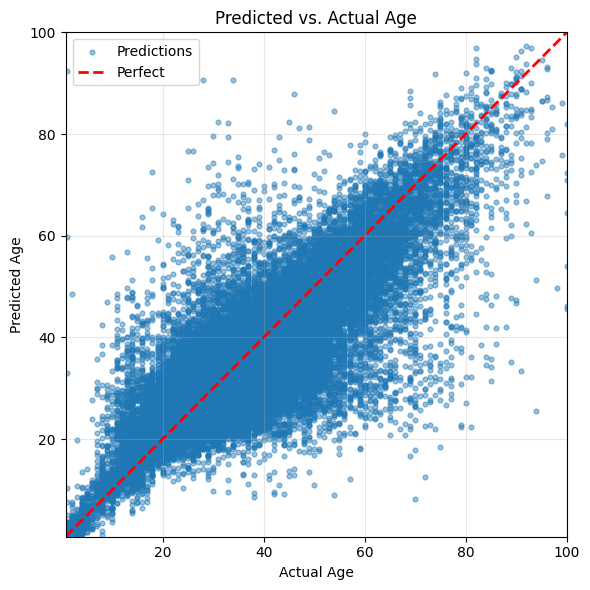

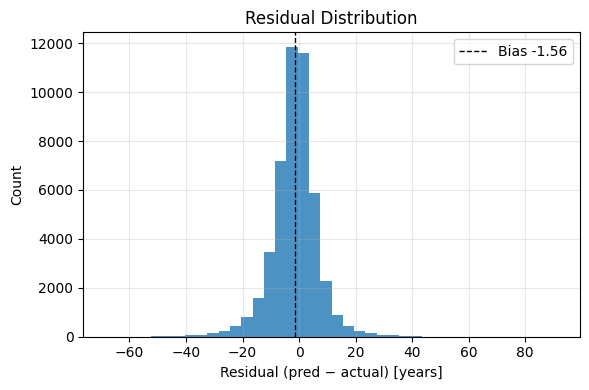

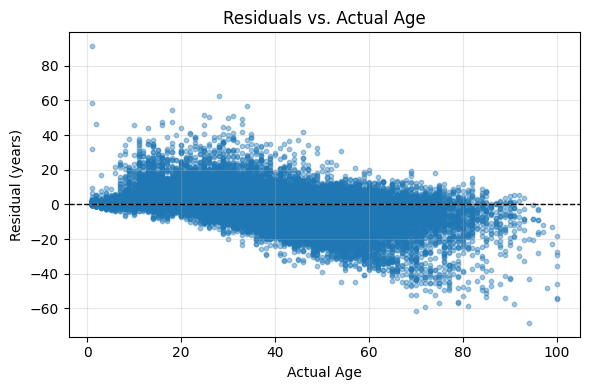

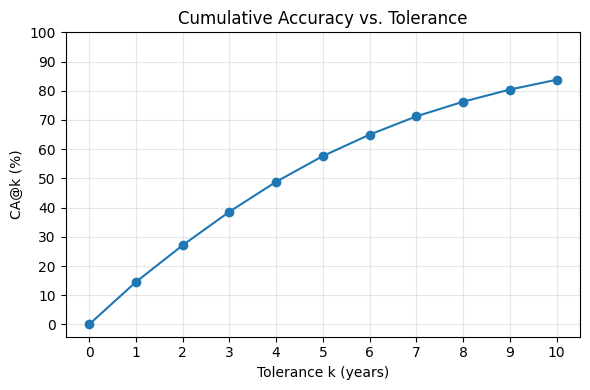

In [49]:
import matplotlib.pyplot as plt

# 1) Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.45, s=12, label="Predictions")
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, 'r--', linewidth=2, label="Perfect")
plt.xlim(lims); plt.ylim(lims)
plt.xlabel("Actual Age"); plt.ylabel("Predicted Age")
plt.title("Predicted vs. Actual Age")
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2) Residual histogram
res = y_pred - y_true
plt.figure(figsize=(6,4))
plt.hist(res, bins=40, alpha=0.8)
plt.axvline(res.mean(), color='k', linestyle='--', linewidth=1, label=f"Bias {res.mean():+.2f}")
plt.xlabel("Residual (pred − actual) [years]")
plt.ylabel("Count")
plt.title("Residual Distribution")
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3) Residuals vs Actual (heteroscedasticity)
plt.figure(figsize=(6,4))
plt.scatter(y_true, res, alpha=0.4, s=10)
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.xlabel("Actual Age"); plt.ylabel("Residual (years)")
plt.title("Residuals vs. Actual Age")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4) CA curve 0..10 years
ks = np.arange(0, 11)
ca_vals = [np.mean(np.abs(y_pred - y_true) <= k) for k in ks]
plt.figure(figsize=(6,4))
plt.plot(ks, np.array(ca_vals)*100, marker='o')
plt.xticks(ks)
plt.yticks(np.arange(0, 101, 10))
plt.xlabel("Tolerance k (years)"); plt.ylabel("CA@k (%)")
plt.title("Cumulative Accuracy vs. Tolerance")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
